<h6>

<font size="6.5"> **Classification of Attacked Networks** </font>

<font size="4.5">Department of Physics, UniTO
    
<font size="4.5">Authors: Carola Maria Caivano, Davide Coppes

## Index
1. [Data Loading](#load_data)
1. [Pre-processing of data](#pre_proc)
1. [Model selection](#model_sel)
    1. [Random forest](#random_forest)
        1. [Search for hyperparameters](#rf_hyper)
        1. [Model evaluation](#rf_eval)
    1. [Neural network](#neural_net)
        1. [Model](#nn_model)
        1. [Search for hyperparameters](#nn_hyper)
        1. [Regularization](#nn_regul)
        1. [Model evaluation](#nn_eval)
1. [Conclusions](#conclusion)    

<a id='load_data'></a>
## 1. Data Loading
The dataset consists of 70560 networks divided in 12 classes:
* Barabasi-Albert intact network, label 0 
* Erdos-Renyi intact network, label 1
* Watts-Strogatz intact network, label 2
* Barabasi-Albert attacked network with random attack, label 3 
* Erdos-Renyi attacked network with random attack, label 4
* Watts-Strogatz attacked network with random attack, label 5
* Barabasi-Albert attacked network with maximum-degree node deletion, label 6 
* Erdos-Renyi attacked network with maximum-degree node deletion, label 7
* Watts-Strogatz attacked network with maximum-degree node deletion, label 8
* Barabasi-Albert attacked network with maximum-betweenness node deletion, label 9
* Erdos-Renyi attacked network with maximum-betweenness node deletion, label 10
* Watts-Strogatz attacked network with maximum-betweenness node deletion, label 11

In [21]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [22]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [23]:
df = pd.read_csv("./Dataset.csv")
df

,Nodes,Links,Degree,Assort,Clust_Coeff,Dist,Label
0,495.0,2450.0,0.115105,-0.048256,0.059808,0.555498,0
1,495.0,2450.0,0.125304,-0.063044,0.058427,0.694520,0
2,495.0,2450.0,0.133770,-0.067241,0.067211,0.691304,0
3,495.0,2450.0,0.101010,-0.098562,0.066583,0.686805,0
4,495.0,2450.0,0.099990,-0.064163,0.067480,0.553004,0
...,...,...,...,...,...,...,...
70555,900.0,3911.0,0.668547,0.134067,0.376908,0.608796,11
70556,900.0,3907.0,0.667863,0.154856,0.387341,0.537351,11
70557,900.0,3903.0,0.667179,0.164840,0.385225,0.611544,11
70558,900.0,3875.0,0.717593,0.137299,0.389684,0.616419,11


The goal of the work is to train a model that can be applied to networks of various sizes. Therefore, to make the input data independent of network size, we eliminate the number of nodes and links and normalize the remaining metrics.

In [24]:
df_data = df.drop(["Nodes", "Links"], axis=1)
df_data

,Degree,Assort,Clust_Coeff,Dist,Label
0,0.115105,-0.048256,0.059808,0.555498,0
1,0.125304,-0.063044,0.058427,0.694520,0
2,0.133770,-0.067241,0.067211,0.691304,0
3,0.101010,-0.098562,0.066583,0.686805,0
4,0.099990,-0.064163,0.067480,0.553004,0
...,...,...,...,...,...
70555,0.668547,0.134067,0.376908,0.608796,11
70556,0.667863,0.154856,0.387341,0.537351,11
70557,0.667179,0.164840,0.385225,0.611544,11
70558,0.717593,0.137299,0.389684,0.616419,11


<a id='pre_proc'></a>
## 2. Pre-processing of data

We shuffle the dataset and divide the data in input and output

In [25]:
# A fraction of data is sampled in random order (here frac=1 means all nodes)
df_data_shuffled = df_data.sample(frac=1)

In [26]:
df_X = df_data_shuffled[["Degree", "Assort", "Clust_Coeff", "Dist"]]
df_X

,Degree,Assort,Clust_Coeff,Dist
19331,0.420955,-0.010711,0.014953,0.595694
38955,0.559048,-0.076252,0.259608,0.532852
17476,0.482759,-0.002269,0.028883,0.656453
5017,0.081536,-0.063785,0.041379,0.592475
11440,0.177485,-0.059827,0.055186,0.663487
...,...,...,...,...
59565,0.704185,0.025576,0.497211,0.563038
68305,0.588039,-0.033073,0.324867,0.551970
62370,0.269806,-0.064551,0.018645,0.607058
69219,0.739683,0.374302,0.496362,0.347242


In [27]:
df_y = df_data_shuffled[["Label"]]
df_y

,Label
19331,5
38955,9
17476,4
5017,1
11440,3
...,...
59565,11
68305,9
62370,2
69219,10


We create a training and test set

In [28]:
f_test = 0.3  # franction of data in the test set

In [29]:
N_test = int(f_test * len(df_y))  # number of data in the test set

df_X_train = df_X.iloc[N_test:, :]
df_X_test = df_X.iloc[:N_test, :]

df_y_train = df_y.iloc[N_test:, :]
df_y_test = df_y.iloc[:N_test, :]

We transform the data to numpy array and apply a standardization feature scaling (features have mean = 0 and variance = 1)

In [30]:
scaler = StandardScaler()

X_train = scaler.fit_transform(df_X_train)
X_test = scaler.fit_transform(df_X_test)

y_train = np.ravel(df_y_train.values)
y_test = np.ravel(df_y_test.values)

<a id='model_sel'></a>
## 3. Model selection
In the following paragraphs we will see the two models used for classification, Random Forest and the Neural Network.

<a id='random_forest'></a>
## 3.1 Random forest

<a id='rf_hyper'></a>
### 3.1.1 Search for hyperparameters

We search a good range for the max_depth hyperparameter and n_estimators hyperparameter, computing the accuracy every time to find the best score.

In [12]:
%%time

depths = np.arange(2, 50, 2)
scores = []

forest = RandomForestClassifier()

for depth in depths:
    forest.max_depth = depth
    cv = KFold(n_splits=10, shuffle=True, random_state=0)

    scores_model = cross_val_score(forest, X_train, y_train, cv=cv)
    scores.append(np.mean(scores_model))

CPU times: user 25min 53s, sys: 2.01 s, total: 25min 55s
Wall time: 25min 55s


Best depth: 18
Best score: 0.7138201524182065


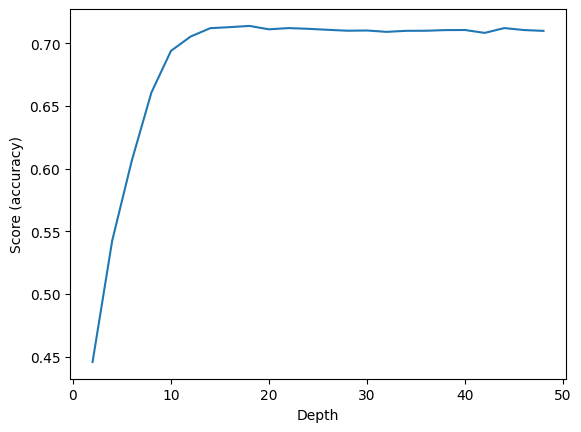

In [13]:
print("Best depth:", depths[np.argmax(scores)])
print("Best score:", scores[np.argmax(scores)])

plt.plot(depths, scores)
plt.xlabel("Depth")
plt.ylabel("Score (accuracy)");

In [14]:
%%time

n_estimators = np.arange(10, 200, 10)
scores = []

forest = RandomForestClassifier(max_depth=18) # !!!!!!!!

for n_estimator in n_estimators:
    forest.n_estimators = n_estimator
    cv = KFold(n_splits=10, shuffle=True, random_state=0)

    scores_model = cross_val_score(forest, X_train, y_train, cv=cv)
    scores.append(np.mean(scores_model))

CPU times: user 22min 52s, sys: 1.2 s, total: 22min 54s
Wall time: 22min 54s


Best number of estimators: 170
Best score: 0.7125648088870454


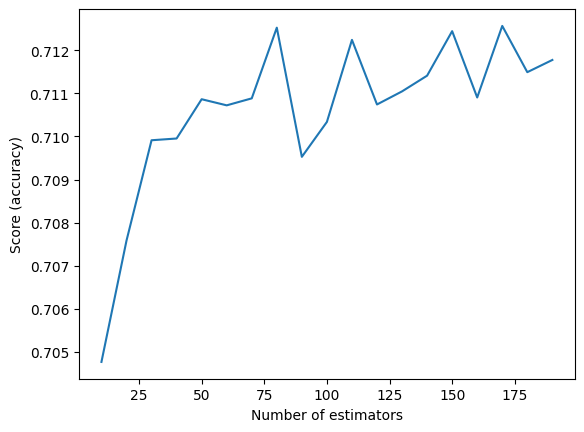

In [15]:
print("Best number of estimators:", n_estimators[np.argmax(scores)])
print("Best score:", scores[np.argmax(scores)])

plt.plot(n_estimators, scores)
plt.xlabel("Number of estimators")
plt.ylabel("Score (accuracy)");

We use gridsearch to find the optimal combination of hyperparameters. The performance of each combination of hyperparameters is evaluated using a cross-validation technique.The optimal combination is chosen based on the highest cross-validation score.

In [17]:
%%time

grid = {
    "max_depth": np.arange(16, 20, 2),
    "n_estimators": np.arange(150, 190, 5),
    "criterion": ["gini", "entropy", "log_loss"],
}

forest = RandomForestClassifier()
cv = KFold(n_splits=10, shuffle=True, random_state=0)

rf_gs = GridSearchCV(forest, grid, cv=cv)
rf_gs.fit(X_train, y_train)

CPU times: user 2h 2min 34s, sys: 5.85 s, total: 2h 2min 40s
Wall time: 2h 2min 41s


GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': array([16, 18]),
                         'n_estimators': array([150, 155, 160, 165, 170, 175, 180, 185])})

In [18]:
rf_gs.best_score_

0.7171606760371266

In [19]:
rf_gs.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=16, n_estimators=150)

We compute the accuracy on the test set.

In [20]:
forest = RandomForestClassifier(criterion='entropy', max_depth=16, n_estimators=150) # !!!!!!!!
forest.fit(X_train, y_train)

y_test_predict = forest.predict(X_test)

accuracy_score(y_test, y_test_predict)

0.6618008314436886

<a id='rf_eval'></a>
### 3.1.2 Model evaluation

We see if the model overfit or underfit plotting the learning curve

In [21]:
%%time

cv = KFold(n_splits=10, shuffle=True, random_state=0)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    forest,
    X_train,
    y_train,
    train_sizes=[0.001, 0.01, 0.1, 0.2, 0.33, 0.5, 0.75, 0.99],
    cv=cv,
    return_times=True,
)

CPU times: user 6min 30s, sys: 2.85 s, total: 6min 33s
Wall time: 6min 34s


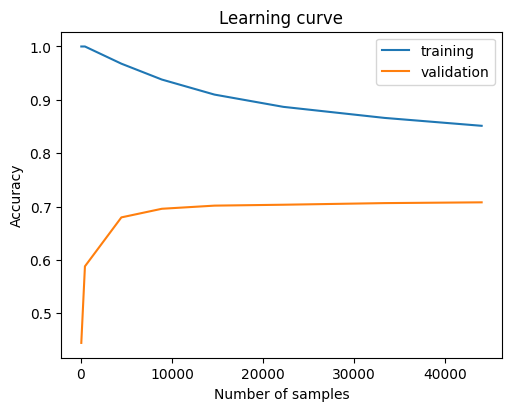

In [22]:
fig, ax = plt.subplots(figsize=(5, 4), layout="constrained")
ax.plot(train_sizes, np.mean(train_scores, axis=1), label="training")
ax.plot(train_sizes, np.mean(test_scores, axis=1), label="validation")
ax.set_xlabel("Number of samples")
ax.set_ylabel("Accuracy")
ax.set_title("Learning curve")
ax.legend();

The model is overfitting.

We decrease the max_depth to try to limit overfitting.

In [14]:
%%time

grid = {
    "max_depth": np.arange(10, 16, 2),
    "n_estimators": np.arange(50, 100, 5),
    "criterion": ["gini", "entropy", "log_loss"],
}

forest = RandomForestClassifier()
cv = KFold(n_splits=10, shuffle=True, random_state=0)

rf_gs = GridSearchCV(forest, grid, cv=cv)
rf_gs.fit(X_train, y_train)

CPU times: user 1h 39min 43s, sys: 1.16 s, total: 1h 39min 44s
Wall time: 1h 39min 45s


GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': array([10, 12, 14]),
                         'n_estimators': array([50, 55, 60, 65, 70, 75, 80, 85, 90, 95])})

In [15]:
rf_gs.best_score_

0.7161483581475375

In [16]:
rf_gs.best_estimator_

RandomForestClassifier(criterion='log_loss', max_depth=14, n_estimators=85)

In [64]:
forest = RandomForestClassifier(criterion='log_loss', max_depth=14, n_estimators=85) # !!!!!!!!
forest.fit(X_train, y_train)

y_test_predict = forest.predict(X_test)

accuracy_score(y_test, y_test_predict)

0.6976568405139834

In [18]:
%%time

cv = KFold(n_splits=10, shuffle=True, random_state=0)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    forest,
    X_train,
    y_train,
    train_sizes=[0.001, 0.01, 0.1, 0.2, 0.33, 0.5, 0.75, 0.99],
    cv=cv,
    return_times=True,
)

CPU times: user 4min 17s, sys: 528 ms, total: 4min 18s
Wall time: 4min 18s


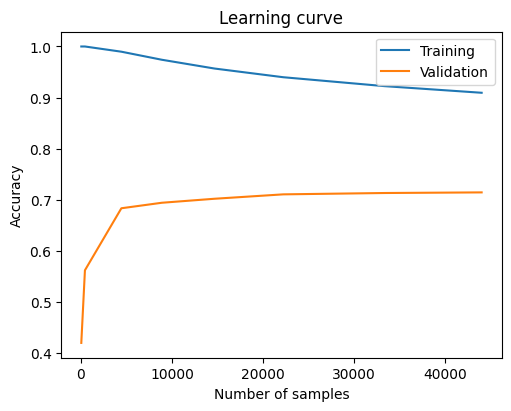

In [19]:
fig, ax = plt.subplots(figsize=(5, 4), layout="constrained")
ax.plot(train_sizes, np.mean(train_scores, axis=1), label="Training")
ax.plot(train_sizes, np.mean(test_scores, axis=1), label="Validation")
ax.set_xlabel("Number of samples")
ax.set_ylabel("Accuracy")
ax.set_title("Learning curve")
ax.legend();

### Confusion Matrix

To better visualize the type of errors in the model, we calculate the confusion matrix

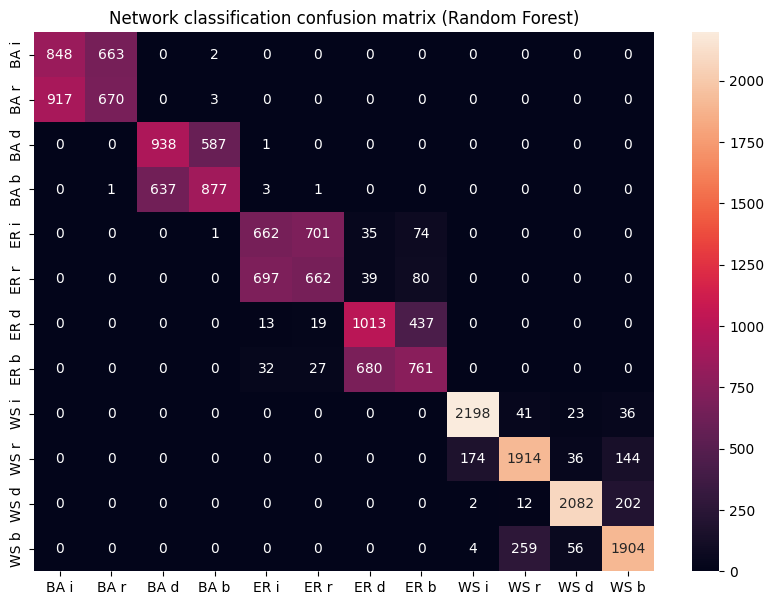

In [20]:
conf = confusion_matrix(y_test, y_test_predict)

index = [
    "BA i",
    "BA r",
    "BA d",
    "BA b",
    "ER i",
    "ER r",
    "ER d",
    "ER b",
    "WS i",
    "WS r",
    "WS d",
    "WS b",
]

df_cm = pd.DataFrame(conf, index=index, columns=index)
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, fmt="d").set_title(
    "Network classification confusion matrix (Random Forest)"
);

In [65]:
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.52      0.55      0.53      1539
           1       0.50      0.47      0.49      1492
           2       0.58      0.61      0.60      1497
           3       0.60      0.57      0.59      1524
           4       0.45      0.46      0.46      1533
           5       0.45      0.47      0.46      1537
           6       0.58      0.63      0.60      1508
           7       0.58      0.50      0.54      1587
           8       0.98      0.98      0.98      2210
           9       0.88      0.91      0.89      2290
          10       0.96      0.94      0.95      2188
          11       0.88      0.87      0.87      2263

    accuracy                           0.70     21168
   macro avg       0.66      0.66      0.66     21168
weighted avg       0.70      0.70      0.70     21168



The confusion matrix shows that the model is unable to distinguish between intact and randomly-attacked networks. 

### Features Importance

We see which are the most important features to make classification  with a model based on feature permutation.

A feature column from the validation set is permuted and the score metric is evaluated; the permutation importance of this feature is defined to be the difference between the score metric without shouffling and metric from permutating the feature column.

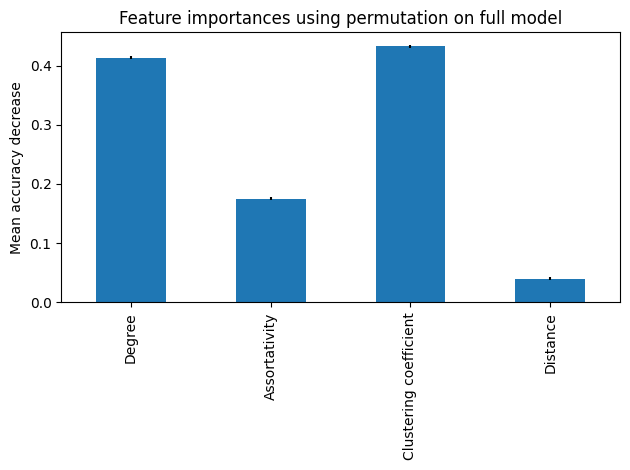

In [21]:
feature_names = ["Degree", "Assortativity", "Clustering coefficient", "Distance"]

result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

<a id='neural_net'></a>
## 3.2 Neural network

<a id='nn_hyper'></a>
### 3.2.1 Model

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch
import keras_tuner as kt
from tensorflow.keras.regularizers import l2
from sklearn.metrics import f1_score

In [32]:
# Define the number of input features and classes
num_features = 4
num_classes = 12

We convert the target variable into a one-hot encoded format.

In [33]:
# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

The neural network is trained a first time with random hyperparameters.

In [25]:
# Define the model architecture
model = Sequential()
model.add(Dense(16, input_dim=num_features, activation="relu", kernel_initializer="glorot_uniform"))
model.add(Dense(32, activation="relu", kernel_initializer="glorot_uniform"))
model.add(Dense(num_classes, activation="softmax", kernel_initializer="glorot_uniform"))

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

2023-05-15 14:47:34.164644: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/100
1544/1544 [==============================] - 1s 573us/step - loss: 1.1165 - accuracy: 0.4747
Epoch 2/100
1544/1544 [==============================] - 1s 550us/step - loss: 0.8641 - accuracy: 0.5439
Epoch 3/100
1544/1544 [==============================] - 1s 582us/step - loss: 0.8399 - accuracy: 0.5537
Epoch 4/100
1544/1544 [==============================] - 1s 573us/step - loss: 0.8279 - accuracy: 0.5577
Epoch 5/100
1544/1544 [==============================] - 1s 550us/step - loss: 0.8191 - accuracy: 0.5575
Epoch 6/100
1544/1544 [==============================] - 1s 557us/step - loss: 0.8113 - accuracy: 0.5590
Epoch 7/100
1544/1544 [==============================] - 1s 574us/step - loss: 0.8052 - accuracy: 0.5646
Epoch 8/100
1544/1544 [==============================] - 1s 561us/step - loss: 0.8004 - accuracy: 0.5635
Epoch 9/100
1544/1544 [==============================] - 1s 563us/step - loss: 0.7962 - accuracy: 0.5687
Epoch 10/100
1544/1544 [==============================]

In [26]:
y_pred = model.predict(X_test)

# Compute the accuracy
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test_labels, y_pred_labels)

print('Accuracy: %.2f%%' % (accuracy * 100))

662/662 [==============================] - 0s 416us/step
Accuracy: 59.13%


<a id='nn_hyper'></a>
### 3.2.2 Search for hyperparameters

The model with the hyperparameters to optimize is defined below. We use randomsearch to find the best combination of hyperparameters

In [34]:
class build_hypermodel(kt.HyperModel):

    # Define the model builder function
    def build(self, hp):
        model = keras.Sequential()
        model.add(
            layers.Dense(
                units=hp.Int("units", min_value=15, max_value=65, step=10),
                input_dim=num_features,
                activation="relu",
                kernel_initializer="glorot_uniform",
            )
        )

        for i in range(hp.Int("num_layers", 1, 5)):
            model.add(
                layers.Dense(
                    units=hp.Int(
                        "units_" + str(i), min_value=15, max_value=85, step=10
                    ),
                    activation="relu",
                    kernel_initializer="glorot_uniform",
                )
            )

        model.add(
            layers.Dense(
                num_classes,
                activation="softmax",
                kernel_initializer="glorot_uniform",
            )
        )

        model.compile(
            loss="categorical_crossentropy",
            optimizer=keras.optimizers.Adam(
                hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3, 1e-4])
            ),
            metrics=["accuracy"],
        )

        return model

    # Fit the training set with different batch sizes
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32, 64]),
            **kwargs,
        )

In [35]:
# Define the tuner
tuner = RandomSearch(
    build_hypermodel(),
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=2,
    directory="my_dir",
    project_name="neural_tuner",
)

tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 15, 'max_value': 65, 'step': 10, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 15, 'max_value': 85, 'step': 10, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


We create a callback to stop training early after reaching a certain value for the validation loss.

In [36]:
stop_early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)

We choose the maximum numbers of epochs

In [37]:
n_epochs = 1500

We run the hyperparameter search.

In [38]:
# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=n_epochs, validation_split=0.2, callbacks=[stop_early])

Trial 20 Complete [00h 01m 52s]
val_accuracy: 0.6486486494541168

Best val_accuracy So Far: 0.6486486494541168
Total elapsed time: 00h 22m 53s
INFO:tensorflow:Oracle triggered exit


In [39]:
# Retrieve the best set of hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [40]:
tuner.results_summary(1)

Results summary
Results in my_dir/neural_tuner
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 19 summary
Hyperparameters:
units: 15
num_layers: 4
units_0: 75
learning_rate: 0.001
units_1: 85
batch_size: 16
units_2: 35
units_3: 35
units_4: 45
Score: 0.6486486494541168


We find the optimal number of epochs to train the model with the hyperparameters obtained from the search.

In [24]:
# Build the model with the optimal hyperparameters and train it on the data for n_epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=n_epochs, validation_split=0.2)

Epoch 1/1500
1235/1235 [==============================] - 2s 894us/step - loss: 1.0275 - accuracy: 0.4928 - val_loss: 0.8804 - val_accuracy: 0.5155
Epoch 2/1500
1235/1235 [==============================] - 1s 791us/step - loss: 0.8457 - accuracy: 0.5446 - val_loss: 0.8318 - val_accuracy: 0.5462
Epoch 3/1500
1235/1235 [==============================] - 1s 785us/step - loss: 0.8251 - accuracy: 0.5539 - val_loss: 0.8193 - val_accuracy: 0.5617
Epoch 4/1500
1235/1235 [==============================] - 1s 784us/step - loss: 0.8133 - accuracy: 0.5572 - val_loss: 0.8096 - val_accuracy: 0.5602
Epoch 5/1500
1235/1235 [==============================] - 1s 784us/step - loss: 0.8021 - accuracy: 0.5619 - val_loss: 0.7879 - val_accuracy: 0.5675
Epoch 6/1500
1235/1235 [==============================] - 1s 782us/step - loss: 0.7945 - accuracy: 0.5640 - val_loss: 0.7779 - val_accuracy: 0.5754
Epoch 7/1500
1235/1235 [==============================] - 1s 788us/step - loss: 0.7889 - accuracy: 0.5700 - val_

1235/1235 [==============================] - 1s 784us/step - loss: 0.6126 - accuracy: 0.6522 - val_loss: 0.5996 - val_accuracy: 0.6665
Epoch 57/1500
1235/1235 [==============================] - 1s 776us/step - loss: 0.6116 - accuracy: 0.6543 - val_loss: 0.6357 - val_accuracy: 0.6399
Epoch 58/1500
1235/1235 [==============================] - 1s 782us/step - loss: 0.6154 - accuracy: 0.6514 - val_loss: 0.6024 - val_accuracy: 0.6571
Epoch 59/1500
1235/1235 [==============================] - 1s 781us/step - loss: 0.6096 - accuracy: 0.6552 - val_loss: 0.6170 - val_accuracy: 0.6602
Epoch 60/1500
1235/1235 [==============================] - 1s 781us/step - loss: 0.6072 - accuracy: 0.6572 - val_loss: 0.7266 - val_accuracy: 0.6101
Epoch 61/1500
1235/1235 [==============================] - 1s 784us/step - loss: 0.6094 - accuracy: 0.6545 - val_loss: 0.6045 - val_accuracy: 0.6592
Epoch 62/1500
1235/1235 [==============================] - 1s 784us/step - loss: 0.6071 - accuracy: 0.6567 - val_loss: 0

1235/1235 [==============================] - 1s 784us/step - loss: 0.5733 - accuracy: 0.6745 - val_loss: 0.5944 - val_accuracy: 0.6602
Epoch 112/1500
1235/1235 [==============================] - 1s 781us/step - loss: 0.5678 - accuracy: 0.6760 - val_loss: 0.5744 - val_accuracy: 0.6719
Epoch 113/1500
1235/1235 [==============================] - 1s 787us/step - loss: 0.5725 - accuracy: 0.6739 - val_loss: 0.5776 - val_accuracy: 0.6692
Epoch 114/1500
1235/1235 [==============================] - 1s 780us/step - loss: 0.5696 - accuracy: 0.6747 - val_loss: 0.6113 - val_accuracy: 0.6497
Epoch 115/1500
1235/1235 [==============================] - 1s 787us/step - loss: 0.5660 - accuracy: 0.6769 - val_loss: 0.6459 - val_accuracy: 0.6428
Epoch 116/1500
1235/1235 [==============================] - 1s 843us/step - loss: 0.5649 - accuracy: 0.6748 - val_loss: 0.5823 - val_accuracy: 0.6710
Epoch 117/1500
1235/1235 [==============================] - 1s 796us/step - loss: 0.5654 - accuracy: 0.6778 - val_l

Epoch 166/1500
1235/1235 [==============================] - 1s 783us/step - loss: 0.5478 - accuracy: 0.6870 - val_loss: 0.5566 - val_accuracy: 0.6802
Epoch 167/1500
1235/1235 [==============================] - 1s 783us/step - loss: 0.5449 - accuracy: 0.6913 - val_loss: 0.6338 - val_accuracy: 0.6454
Epoch 168/1500
1235/1235 [==============================] - 1s 781us/step - loss: 0.5459 - accuracy: 0.6892 - val_loss: 0.5617 - val_accuracy: 0.6761
Epoch 169/1500
1235/1235 [==============================] - 1s 784us/step - loss: 0.5489 - accuracy: 0.6865 - val_loss: 0.5615 - val_accuracy: 0.6831
Epoch 170/1500
1235/1235 [==============================] - 1s 779us/step - loss: 0.5446 - accuracy: 0.6891 - val_loss: 0.5547 - val_accuracy: 0.6784
Epoch 171/1500
1235/1235 [==============================] - 1s 789us/step - loss: 0.5499 - accuracy: 0.6880 - val_loss: 0.5593 - val_accuracy: 0.6796
Epoch 172/1500
1235/1235 [==============================] - 1s 785us/step - loss: 0.5475 - accuracy:

Epoch 275/1500
1235/1235 [==============================] - 1s 789us/step - loss: 0.5245 - accuracy: 0.6987 - val_loss: 0.5928 - val_accuracy: 0.6769
Epoch 276/1500
1235/1235 [==============================] - 1s 789us/step - loss: 0.5182 - accuracy: 0.7003 - val_loss: 0.5438 - val_accuracy: 0.6805
Epoch 277/1500
1235/1235 [==============================] - 1s 783us/step - loss: 0.5248 - accuracy: 0.6971 - val_loss: 0.5405 - val_accuracy: 0.6917
Epoch 278/1500
1235/1235 [==============================] - 1s 787us/step - loss: 0.5264 - accuracy: 0.6962 - val_loss: 0.5566 - val_accuracy: 0.6904
Epoch 279/1500
1235/1235 [==============================] - 1s 807us/step - loss: 0.5197 - accuracy: 0.6999 - val_loss: 0.5363 - val_accuracy: 0.6842
Epoch 280/1500
1235/1235 [==============================] - 1s 816us/step - loss: 0.5327 - accuracy: 0.6973 - val_loss: 0.5457 - val_accuracy: 0.6863
Epoch 281/1500
1235/1235 [==============================] - 1s 785us/step - loss: 0.5190 - accuracy:

Epoch 384/1500
1235/1235 [==============================] - 1s 789us/step - loss: 0.5075 - accuracy: 0.7021 - val_loss: 0.5391 - val_accuracy: 0.6938
Epoch 385/1500
1235/1235 [==============================] - 1s 785us/step - loss: 0.5058 - accuracy: 0.7033 - val_loss: 0.5775 - val_accuracy: 0.6655
Epoch 386/1500
1235/1235 [==============================] - 1s 794us/step - loss: 0.5097 - accuracy: 0.7034 - val_loss: 0.5537 - val_accuracy: 0.6881
Epoch 387/1500
1235/1235 [==============================] - 1s 786us/step - loss: 0.5108 - accuracy: 0.7034 - val_loss: 0.5521 - val_accuracy: 0.6868
Epoch 388/1500
1235/1235 [==============================] - 1s 784us/step - loss: 0.5213 - accuracy: 0.7006 - val_loss: 0.5334 - val_accuracy: 0.6893
Epoch 389/1500
1235/1235 [==============================] - 1s 786us/step - loss: 0.5092 - accuracy: 0.7026 - val_loss: 0.5414 - val_accuracy: 0.6915
Epoch 390/1500
1235/1235 [==============================] - 1s 837us/step - loss: 0.5054 - accuracy:

Epoch 493/1500
1235/1235 [==============================] - 1s 801us/step - loss: 0.5001 - accuracy: 0.7092 - val_loss: 0.5591 - val_accuracy: 0.6926
Epoch 494/1500
1235/1235 [==============================] - 1s 807us/step - loss: 0.4996 - accuracy: 0.7094 - val_loss: 0.5327 - val_accuracy: 0.6914
Epoch 495/1500
1235/1235 [==============================] - 1s 808us/step - loss: 0.5012 - accuracy: 0.7103 - val_loss: 0.5570 - val_accuracy: 0.6814
Epoch 496/1500
1235/1235 [==============================] - 1s 808us/step - loss: 0.5022 - accuracy: 0.7087 - val_loss: 0.5352 - val_accuracy: 0.6921
Epoch 497/1500
1235/1235 [==============================] - 1s 820us/step - loss: 0.4947 - accuracy: 0.7099 - val_loss: 0.5538 - val_accuracy: 0.6872
Epoch 498/1500
1235/1235 [==============================] - 1s 820us/step - loss: 0.5005 - accuracy: 0.7101 - val_loss: 0.6101 - val_accuracy: 0.6693
Epoch 499/1500
1235/1235 [==============================] - 1s 808us/step - loss: 0.5221 - accuracy:

Epoch 602/1500
1235/1235 [==============================] - 1s 836us/step - loss: 0.4951 - accuracy: 0.7137 - val_loss: 0.5530 - val_accuracy: 0.6957
Epoch 603/1500
1235/1235 [==============================] - 1s 793us/step - loss: 0.4931 - accuracy: 0.7137 - val_loss: 0.5445 - val_accuracy: 0.6899
Epoch 604/1500
1235/1235 [==============================] - 1s 795us/step - loss: 0.4911 - accuracy: 0.7136 - val_loss: 0.5348 - val_accuracy: 0.6998
Epoch 605/1500
1235/1235 [==============================] - 1s 790us/step - loss: 0.4964 - accuracy: 0.7136 - val_loss: 0.5577 - val_accuracy: 0.6904
Epoch 606/1500
1235/1235 [==============================] - 1s 788us/step - loss: 0.4919 - accuracy: 0.7154 - val_loss: 0.5465 - val_accuracy: 0.6918
Epoch 607/1500
1235/1235 [==============================] - 1s 789us/step - loss: 0.4918 - accuracy: 0.7135 - val_loss: 0.5501 - val_accuracy: 0.6886
Epoch 608/1500
1235/1235 [==============================] - 1s 785us/step - loss: 0.4938 - accuracy:

Epoch 711/1500
1235/1235 [==============================] - 1s 789us/step - loss: 0.4864 - accuracy: 0.7152 - val_loss: 0.5888 - val_accuracy: 0.6839
Epoch 712/1500
1235/1235 [==============================] - 1s 795us/step - loss: 0.4879 - accuracy: 0.7160 - val_loss: 0.5533 - val_accuracy: 0.6967
Epoch 713/1500
1235/1235 [==============================] - 1s 787us/step - loss: 0.4894 - accuracy: 0.7142 - val_loss: 0.5855 - val_accuracy: 0.6813
Epoch 714/1500
1235/1235 [==============================] - 1s 788us/step - loss: 0.4855 - accuracy: 0.7183 - val_loss: 0.5334 - val_accuracy: 0.6952
Epoch 715/1500
1235/1235 [==============================] - 1s 784us/step - loss: 0.4883 - accuracy: 0.7157 - val_loss: 0.5452 - val_accuracy: 0.7065
Epoch 716/1500
1235/1235 [==============================] - 1s 842us/step - loss: 0.4895 - accuracy: 0.7136 - val_loss: 0.5419 - val_accuracy: 0.6935
Epoch 717/1500
1235/1235 [==============================] - 1s 792us/step - loss: 0.4885 - accuracy:

Epoch 820/1500
1235/1235 [==============================] - 1s 799us/step - loss: 0.4930 - accuracy: 0.7153 - val_loss: 0.5434 - val_accuracy: 0.6957
Epoch 821/1500
1235/1235 [==============================] - 1s 791us/step - loss: 0.4768 - accuracy: 0.7226 - val_loss: 0.5591 - val_accuracy: 0.6859
Epoch 822/1500
1235/1235 [==============================] - 1s 792us/step - loss: 0.4845 - accuracy: 0.7195 - val_loss: 0.5423 - val_accuracy: 0.7021
Epoch 823/1500
1235/1235 [==============================] - 1s 806us/step - loss: 0.4849 - accuracy: 0.7199 - val_loss: 0.5677 - val_accuracy: 0.6803
Epoch 824/1500
1235/1235 [==============================] - 1s 793us/step - loss: 0.4814 - accuracy: 0.7184 - val_loss: 0.5573 - val_accuracy: 0.6950
Epoch 825/1500
1235/1235 [==============================] - 1s 796us/step - loss: 0.4864 - accuracy: 0.7162 - val_loss: 0.5674 - val_accuracy: 0.6847
Epoch 826/1500
1235/1235 [==============================] - 1s 790us/step - loss: 0.4804 - accuracy:

Epoch 929/1500
1235/1235 [==============================] - 1s 789us/step - loss: 0.4784 - accuracy: 0.7207 - val_loss: 0.5387 - val_accuracy: 0.7038
Epoch 930/1500
1235/1235 [==============================] - 1s 795us/step - loss: 0.4758 - accuracy: 0.7217 - val_loss: 0.5326 - val_accuracy: 0.6977
Epoch 931/1500
1235/1235 [==============================] - 1s 792us/step - loss: 0.4790 - accuracy: 0.7206 - val_loss: 0.5647 - val_accuracy: 0.6891
Epoch 932/1500
1235/1235 [==============================] - 1s 792us/step - loss: 0.4774 - accuracy: 0.7200 - val_loss: 0.5596 - val_accuracy: 0.6905
Epoch 933/1500
1235/1235 [==============================] - 1s 803us/step - loss: 0.4889 - accuracy: 0.7169 - val_loss: 0.5376 - val_accuracy: 0.7022
Epoch 934/1500
1235/1235 [==============================] - 1s 792us/step - loss: 0.4779 - accuracy: 0.7215 - val_loss: 0.5489 - val_accuracy: 0.6888
Epoch 935/1500
1235/1235 [==============================] - 1s 793us/step - loss: 0.4959 - accuracy:

1235/1235 [==============================] - 1s 793us/step - loss: 0.4744 - accuracy: 0.7221 - val_loss: 0.5354 - val_accuracy: 0.6968
Epoch 1038/1500
1235/1235 [==============================] - 1s 792us/step - loss: 0.4801 - accuracy: 0.7208 - val_loss: 0.5620 - val_accuracy: 0.6862
Epoch 1039/1500
1235/1235 [==============================] - 1s 788us/step - loss: 0.4788 - accuracy: 0.7222 - val_loss: 0.5610 - val_accuracy: 0.6957
Epoch 1040/1500
1235/1235 [==============================] - 1s 828us/step - loss: 0.4843 - accuracy: 0.7200 - val_loss: 0.5858 - val_accuracy: 0.6900
Epoch 1041/1500
1235/1235 [==============================] - 1s 801us/step - loss: 0.4883 - accuracy: 0.7171 - val_loss: 0.5492 - val_accuracy: 0.6999
Epoch 1042/1500
1235/1235 [==============================] - 1s 791us/step - loss: 0.4788 - accuracy: 0.7211 - val_loss: 0.5420 - val_accuracy: 0.6988
Epoch 1043/1500
1235/1235 [==============================] - 1s 789us/step - loss: 0.4846 - accuracy: 0.7205 -

1235/1235 [==============================] - 1s 799us/step - loss: 0.4783 - accuracy: 0.7204 - val_loss: 0.5578 - val_accuracy: 0.6988
Epoch 1146/1500
1235/1235 [==============================] - 1s 807us/step - loss: 0.4713 - accuracy: 0.7231 - val_loss: 0.5597 - val_accuracy: 0.6972
Epoch 1147/1500
1235/1235 [==============================] - 1s 789us/step - loss: 0.4851 - accuracy: 0.7165 - val_loss: 0.5509 - val_accuracy: 0.6848
Epoch 1148/1500
1235/1235 [==============================] - 1s 794us/step - loss: 0.4733 - accuracy: 0.7237 - val_loss: 0.5829 - val_accuracy: 0.6862
Epoch 1149/1500
1235/1235 [==============================] - 1s 791us/step - loss: 0.5032 - accuracy: 0.7115 - val_loss: 0.5771 - val_accuracy: 0.6812
Epoch 1150/1500
1235/1235 [==============================] - 1s 800us/step - loss: 0.4950 - accuracy: 0.7111 - val_loss: 0.5562 - val_accuracy: 0.6989
Epoch 1151/1500
1235/1235 [==============================] - 1s 792us/step - loss: 0.4866 - accuracy: 0.7182 -

1235/1235 [==============================] - 1s 793us/step - loss: 0.4744 - accuracy: 0.7221 - val_loss: 0.5384 - val_accuracy: 0.6988
Epoch 1254/1500
1235/1235 [==============================] - 1s 790us/step - loss: 0.4855 - accuracy: 0.7185 - val_loss: 0.5456 - val_accuracy: 0.6946
Epoch 1255/1500
1235/1235 [==============================] - 1s 791us/step - loss: 0.4742 - accuracy: 0.7254 - val_loss: 0.5603 - val_accuracy: 0.6932
Epoch 1256/1500
1235/1235 [==============================] - 1s 793us/step - loss: 0.4723 - accuracy: 0.7221 - val_loss: 0.5516 - val_accuracy: 0.6902
Epoch 1257/1500
1235/1235 [==============================] - 1s 789us/step - loss: 0.4756 - accuracy: 0.7224 - val_loss: 0.5491 - val_accuracy: 0.6915
Epoch 1258/1500
1235/1235 [==============================] - 1s 790us/step - loss: 0.4720 - accuracy: 0.7248 - val_loss: 0.6739 - val_accuracy: 0.6670
Epoch 1259/1500
1235/1235 [==============================] - 1s 794us/step - loss: 0.4766 - accuracy: 0.7242 -

1235/1235 [==============================] - 1s 795us/step - loss: 0.4797 - accuracy: 0.7216 - val_loss: 0.5460 - val_accuracy: 0.6978
Epoch 1362/1500
1235/1235 [==============================] - 1s 802us/step - loss: 0.4781 - accuracy: 0.7214 - val_loss: 0.5438 - val_accuracy: 0.6942
Epoch 1363/1500
1235/1235 [==============================] - 1s 806us/step - loss: 0.4743 - accuracy: 0.7191 - val_loss: 0.5710 - val_accuracy: 0.6865
Epoch 1364/1500
1235/1235 [==============================] - 1s 814us/step - loss: 0.4700 - accuracy: 0.7231 - val_loss: 0.5440 - val_accuracy: 0.6988
Epoch 1365/1500
1235/1235 [==============================] - 1s 810us/step - loss: 0.4749 - accuracy: 0.7226 - val_loss: 0.5434 - val_accuracy: 0.6994
Epoch 1366/1500
1235/1235 [==============================] - 1s 794us/step - loss: 0.4706 - accuracy: 0.7244 - val_loss: 0.5525 - val_accuracy: 0.7020
Epoch 1367/1500
1235/1235 [==============================] - 1s 794us/step - loss: 0.4740 - accuracy: 0.7209 -

1235/1235 [==============================] - 1s 793us/step - loss: 0.4728 - accuracy: 0.7239 - val_loss: 0.5538 - val_accuracy: 0.6869
Epoch 1470/1500
1235/1235 [==============================] - 1s 790us/step - loss: 0.4724 - accuracy: 0.7234 - val_loss: 0.5687 - val_accuracy: 0.6905
Epoch 1471/1500
1235/1235 [==============================] - 1s 787us/step - loss: 0.4720 - accuracy: 0.7239 - val_loss: 0.5468 - val_accuracy: 0.7029
Epoch 1472/1500
1235/1235 [==============================] - 1s 799us/step - loss: 0.4732 - accuracy: 0.7253 - val_loss: 0.5569 - val_accuracy: 0.7004
Epoch 1473/1500
1235/1235 [==============================] - 1s 793us/step - loss: 0.4875 - accuracy: 0.7210 - val_loss: 0.5536 - val_accuracy: 0.6958
Epoch 1474/1500
1235/1235 [==============================] - 1s 788us/step - loss: 0.4728 - accuracy: 0.7257 - val_loss: 0.5546 - val_accuracy: 0.6937
Epoch 1475/1500
1235/1235 [==============================] - 1s 792us/step - loss: 0.4914 - accuracy: 0.7194 -

In [25]:
val_acc_per_epoch = history.history["val_accuracy"]
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print("Best epoch: %d" % (best_epoch,))

Best epoch: 1027


We see if the model overfit or underfit plotting the learning curves on the epochs

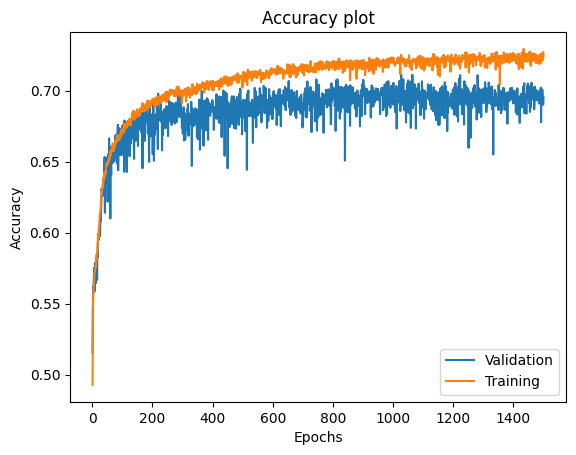

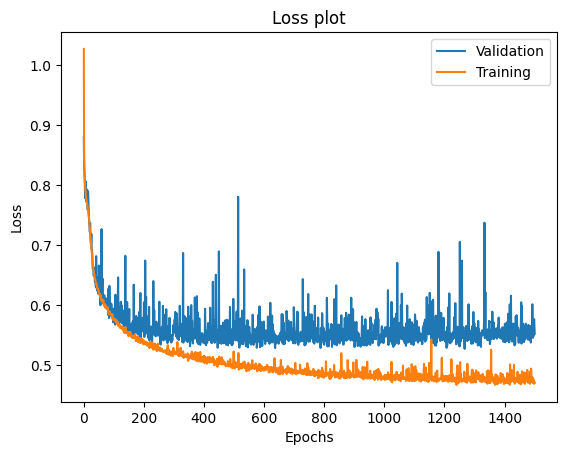

In [26]:
plot_epochs = [i for i in range(1, n_epochs + 1)]
plt.plot(plot_epochs, val_acc_per_epoch, label="Validation")
plt.plot(plot_epochs, history.history["accuracy"], label="Training")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.title("Accuracy plot")
plt.show()

plt.plot(plot_epochs, history.history["val_loss"], label="Validation")
plt.plot(plot_epochs, history.history["loss"], label="Training")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.title("Loss plot")
plt.show()

We can see that the model is overfitting. If we look loss plot we see that the plot of training loss continues to decrease with experience, the plot of validation loss decreases to a point and then seems to increase again. 

We re-instantiate the hypermodel and train it with the optimal number of epochs from above.

In [27]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/1027
1235/1235 [==============================] - 2s 854us/step - loss: 1.0359 - accuracy: 0.4755 - val_loss: 0.8778 - val_accuracy: 0.5228
Epoch 2/1027
1235/1235 [==============================] - 1s 793us/step - loss: 0.8570 - accuracy: 0.5276 - val_loss: 0.8324 - val_accuracy: 0.5421
Epoch 3/1027
1235/1235 [==============================] - 1s 802us/step - loss: 0.8313 - accuracy: 0.5407 - val_loss: 0.8253 - val_accuracy: 0.5451
Epoch 4/1027
1235/1235 [==============================] - 1s 787us/step - loss: 0.8158 - accuracy: 0.5526 - val_loss: 0.8072 - val_accuracy: 0.5633
Epoch 5/1027
1235/1235 [==============================] - 1s 785us/step - loss: 0.8055 - accuracy: 0.5583 - val_loss: 0.7995 - val_accuracy: 0.5664
Epoch 6/1027
1235/1235 [==============================] - 1s 774us/step - loss: 0.7974 - accuracy: 0.5605 - val_loss: 0.8053 - val_accuracy: 0.5528
Epoch 7/1027
1235/1235 [==============================] - 1s 791us/step - loss: 0.7918 - accuracy: 0.5681 - val_

1235/1235 [==============================] - 1s 836us/step - loss: 0.6199 - accuracy: 0.6527 - val_loss: 0.6288 - val_accuracy: 0.6490
Epoch 57/1027
1235/1235 [==============================] - 1s 825us/step - loss: 0.6221 - accuracy: 0.6517 - val_loss: 0.6199 - val_accuracy: 0.6448
Epoch 58/1027
1235/1235 [==============================] - 1s 802us/step - loss: 0.6178 - accuracy: 0.6554 - val_loss: 0.6244 - val_accuracy: 0.6456
Epoch 59/1027
1235/1235 [==============================] - 1s 816us/step - loss: 0.6166 - accuracy: 0.6548 - val_loss: 0.6208 - val_accuracy: 0.6432
Epoch 60/1027
1235/1235 [==============================] - 1s 815us/step - loss: 0.6172 - accuracy: 0.6536 - val_loss: 0.6215 - val_accuracy: 0.6490
Epoch 61/1027
1235/1235 [==============================] - 1s 801us/step - loss: 0.6144 - accuracy: 0.6532 - val_loss: 0.6683 - val_accuracy: 0.6252
Epoch 62/1027
1235/1235 [==============================] - 1s 831us/step - loss: 0.6122 - accuracy: 0.6568 - val_loss: 0

1235/1235 [==============================] - 1s 781us/step - loss: 0.5763 - accuracy: 0.6727 - val_loss: 0.5886 - val_accuracy: 0.6711
Epoch 112/1027
1235/1235 [==============================] - 1s 785us/step - loss: 0.5793 - accuracy: 0.6733 - val_loss: 0.5948 - val_accuracy: 0.6688
Epoch 113/1027
1235/1235 [==============================] - 1s 798us/step - loss: 0.5782 - accuracy: 0.6744 - val_loss: 0.6147 - val_accuracy: 0.6611
Epoch 114/1027
1235/1235 [==============================] - 1s 774us/step - loss: 0.5711 - accuracy: 0.6727 - val_loss: 0.5890 - val_accuracy: 0.6694
Epoch 115/1027
1235/1235 [==============================] - 1s 797us/step - loss: 0.5728 - accuracy: 0.6756 - val_loss: 0.5925 - val_accuracy: 0.6717
Epoch 116/1027
1235/1235 [==============================] - 1s 801us/step - loss: 0.5762 - accuracy: 0.6727 - val_loss: 0.5789 - val_accuracy: 0.6699
Epoch 117/1027
1235/1235 [==============================] - 1s 813us/step - loss: 0.5718 - accuracy: 0.6777 - val_l

Epoch 166/1027
1235/1235 [==============================] - 1s 795us/step - loss: 0.5573 - accuracy: 0.6813 - val_loss: 0.5865 - val_accuracy: 0.6685
Epoch 167/1027
1235/1235 [==============================] - 1s 764us/step - loss: 0.5552 - accuracy: 0.6824 - val_loss: 0.5940 - val_accuracy: 0.6669
Epoch 168/1027
1235/1235 [==============================] - 1s 800us/step - loss: 0.5558 - accuracy: 0.6811 - val_loss: 0.6133 - val_accuracy: 0.6553
Epoch 169/1027
1235/1235 [==============================] - 1s 845us/step - loss: 0.5544 - accuracy: 0.6835 - val_loss: 0.5849 - val_accuracy: 0.6768
Epoch 170/1027
1235/1235 [==============================] - 1s 862us/step - loss: 0.5526 - accuracy: 0.6871 - val_loss: 0.5874 - val_accuracy: 0.6688
Epoch 171/1027
1235/1235 [==============================] - 1s 872us/step - loss: 0.5555 - accuracy: 0.6840 - val_loss: 0.5717 - val_accuracy: 0.6732
Epoch 172/1027
1235/1235 [==============================] - 1s 849us/step - loss: 0.5536 - accuracy:

Epoch 221/1027
1235/1235 [==============================] - 1s 806us/step - loss: 0.5395 - accuracy: 0.6929 - val_loss: 0.5765 - val_accuracy: 0.6705
Epoch 222/1027
1235/1235 [==============================] - 1s 808us/step - loss: 0.5403 - accuracy: 0.6902 - val_loss: 0.5746 - val_accuracy: 0.6695
Epoch 223/1027
1235/1235 [==============================] - 1s 817us/step - loss: 0.5365 - accuracy: 0.6909 - val_loss: 0.5791 - val_accuracy: 0.6760
Epoch 224/1027
1235/1235 [==============================] - 1s 841us/step - loss: 0.5357 - accuracy: 0.6927 - val_loss: 0.5645 - val_accuracy: 0.6852
Epoch 225/1027
1235/1235 [==============================] - 1s 860us/step - loss: 0.5442 - accuracy: 0.6903 - val_loss: 0.5835 - val_accuracy: 0.6710
Epoch 226/1027
1235/1235 [==============================] - 1s 810us/step - loss: 0.5369 - accuracy: 0.6922 - val_loss: 0.5704 - val_accuracy: 0.6820
Epoch 227/1027
1235/1235 [==============================] - 1s 870us/step - loss: 0.5365 - accuracy:

Epoch 330/1027
1235/1235 [==============================] - 1s 784us/step - loss: 0.5141 - accuracy: 0.7051 - val_loss: 0.5503 - val_accuracy: 0.6911
Epoch 331/1027
1235/1235 [==============================] - 1s 784us/step - loss: 0.5145 - accuracy: 0.7071 - val_loss: 0.5758 - val_accuracy: 0.6776
Epoch 332/1027
1235/1235 [==============================] - 1s 833us/step - loss: 0.5164 - accuracy: 0.7031 - val_loss: 0.5593 - val_accuracy: 0.6884
Epoch 333/1027
1235/1235 [==============================] - 1s 946us/step - loss: 0.5175 - accuracy: 0.7008 - val_loss: 0.5467 - val_accuracy: 0.6919
Epoch 334/1027
1235/1235 [==============================] - 1s 780us/step - loss: 0.5135 - accuracy: 0.7040 - val_loss: 0.5569 - val_accuracy: 0.6842
Epoch 335/1027
1235/1235 [==============================] - 1s 771us/step - loss: 0.5150 - accuracy: 0.7023 - val_loss: 0.5553 - val_accuracy: 0.6876
Epoch 336/1027
1235/1235 [==============================] - 1s 778us/step - loss: 0.5179 - accuracy:

Epoch 439/1027
1235/1235 [==============================] - 1s 769us/step - loss: 0.5075 - accuracy: 0.7059 - val_loss: 0.5568 - val_accuracy: 0.6824
Epoch 440/1027
1235/1235 [==============================] - 1s 775us/step - loss: 0.5085 - accuracy: 0.7062 - val_loss: 0.5486 - val_accuracy: 0.6909
Epoch 441/1027
1235/1235 [==============================] - 1s 771us/step - loss: 0.5062 - accuracy: 0.7065 - val_loss: 0.5464 - val_accuracy: 0.6954
Epoch 442/1027
1235/1235 [==============================] - 1s 759us/step - loss: 0.5062 - accuracy: 0.7081 - val_loss: 0.5423 - val_accuracy: 0.6957
Epoch 443/1027
1235/1235 [==============================] - 1s 753us/step - loss: 0.5044 - accuracy: 0.7078 - val_loss: 0.5692 - val_accuracy: 0.6904
Epoch 444/1027
1235/1235 [==============================] - 1s 757us/step - loss: 0.5134 - accuracy: 0.7057 - val_loss: 0.5464 - val_accuracy: 0.6937
Epoch 445/1027
1235/1235 [==============================] - 1s 755us/step - loss: 0.5077 - accuracy:

Epoch 548/1027
1235/1235 [==============================] - 1s 806us/step - loss: 0.4972 - accuracy: 0.7106 - val_loss: 0.5504 - val_accuracy: 0.6922
Epoch 549/1027
1235/1235 [==============================] - 1s 810us/step - loss: 0.4990 - accuracy: 0.7092 - val_loss: 0.5333 - val_accuracy: 0.6982
Epoch 550/1027
1235/1235 [==============================] - 1s 851us/step - loss: 0.4941 - accuracy: 0.7113 - val_loss: 0.5484 - val_accuracy: 0.6934
Epoch 551/1027
1235/1235 [==============================] - 1s 837us/step - loss: 0.5053 - accuracy: 0.7086 - val_loss: 0.5569 - val_accuracy: 0.6963
Epoch 552/1027
1235/1235 [==============================] - 1s 798us/step - loss: 0.4963 - accuracy: 0.7154 - val_loss: 0.5591 - val_accuracy: 0.6840
Epoch 553/1027
1235/1235 [==============================] - 1s 791us/step - loss: 0.4993 - accuracy: 0.7114 - val_loss: 0.5500 - val_accuracy: 0.6796
Epoch 554/1027
1235/1235 [==============================] - 1s 793us/step - loss: 0.4952 - accuracy:

Epoch 657/1027
1235/1235 [==============================] - 1s 832us/step - loss: 0.4950 - accuracy: 0.7126 - val_loss: 0.5580 - val_accuracy: 0.6861
Epoch 658/1027
1235/1235 [==============================] - 1s 750us/step - loss: 0.4932 - accuracy: 0.7131 - val_loss: 0.5490 - val_accuracy: 0.6892
Epoch 659/1027
1235/1235 [==============================] - 1s 796us/step - loss: 0.4922 - accuracy: 0.7138 - val_loss: 0.5756 - val_accuracy: 0.6726
Epoch 660/1027
1235/1235 [==============================] - 1s 792us/step - loss: 0.4986 - accuracy: 0.7109 - val_loss: 0.5548 - val_accuracy: 0.6919
Epoch 661/1027
1235/1235 [==============================] - 1s 793us/step - loss: 0.4948 - accuracy: 0.7126 - val_loss: 0.5666 - val_accuracy: 0.6918
Epoch 662/1027
1235/1235 [==============================] - 1s 771us/step - loss: 0.5036 - accuracy: 0.7100 - val_loss: 0.5650 - val_accuracy: 0.6851
Epoch 663/1027
1235/1235 [==============================] - 1s 806us/step - loss: 0.4974 - accuracy:

Epoch 766/1027
1235/1235 [==============================] - 1s 795us/step - loss: 0.4873 - accuracy: 0.7163 - val_loss: 0.6115 - val_accuracy: 0.6574
Epoch 767/1027
1235/1235 [==============================] - 1s 799us/step - loss: 0.4936 - accuracy: 0.7114 - val_loss: 0.5969 - val_accuracy: 0.6805
Epoch 768/1027
1235/1235 [==============================] - 1s 794us/step - loss: 0.4951 - accuracy: 0.7128 - val_loss: 0.5449 - val_accuracy: 0.7062
Epoch 769/1027
1235/1235 [==============================] - 1s 797us/step - loss: 0.4888 - accuracy: 0.7184 - val_loss: 0.5610 - val_accuracy: 0.7005
Epoch 770/1027
1235/1235 [==============================] - 1s 826us/step - loss: 0.4981 - accuracy: 0.7120 - val_loss: 0.5431 - val_accuracy: 0.6968
Epoch 771/1027
1235/1235 [==============================] - 1s 800us/step - loss: 0.4904 - accuracy: 0.7158 - val_loss: 0.5587 - val_accuracy: 0.6883
Epoch 772/1027
1235/1235 [==============================] - 1s 802us/step - loss: 0.4916 - accuracy:

Epoch 875/1027
1235/1235 [==============================] - 1s 837us/step - loss: 0.4869 - accuracy: 0.7191 - val_loss: 0.5503 - val_accuracy: 0.6927
Epoch 876/1027
1235/1235 [==============================] - 1s 817us/step - loss: 0.4817 - accuracy: 0.7184 - val_loss: 0.5666 - val_accuracy: 0.6896
Epoch 877/1027
1235/1235 [==============================] - 1s 820us/step - loss: 0.4912 - accuracy: 0.7174 - val_loss: 0.5537 - val_accuracy: 0.6945
Epoch 878/1027
1235/1235 [==============================] - 1s 815us/step - loss: 0.4832 - accuracy: 0.7172 - val_loss: 0.5450 - val_accuracy: 0.7036
Epoch 879/1027
1235/1235 [==============================] - 1s 867us/step - loss: 0.4920 - accuracy: 0.7147 - val_loss: 0.5579 - val_accuracy: 0.6961
Epoch 880/1027
1235/1235 [==============================] - 1s 863us/step - loss: 0.4813 - accuracy: 0.7188 - val_loss: 0.5564 - val_accuracy: 0.6969
Epoch 881/1027
1235/1235 [==============================] - 1s 834us/step - loss: 0.4897 - accuracy:

Epoch 984/1027
1235/1235 [==============================] - 1s 799us/step - loss: 0.4845 - accuracy: 0.7194 - val_loss: 0.5737 - val_accuracy: 0.6805
Epoch 985/1027
1235/1235 [==============================] - 1s 803us/step - loss: 0.4819 - accuracy: 0.7170 - val_loss: 0.5676 - val_accuracy: 0.6854
Epoch 986/1027
1235/1235 [==============================] - 1s 825us/step - loss: 0.4873 - accuracy: 0.7183 - val_loss: 0.5661 - val_accuracy: 0.6911
Epoch 987/1027
1235/1235 [==============================] - 1s 818us/step - loss: 0.4887 - accuracy: 0.7183 - val_loss: 0.5442 - val_accuracy: 0.6940
Epoch 988/1027
1235/1235 [==============================] - 1s 800us/step - loss: 0.4833 - accuracy: 0.7185 - val_loss: 0.5489 - val_accuracy: 0.6953
Epoch 989/1027
1235/1235 [==============================] - 1s 817us/step - loss: 0.4845 - accuracy: 0.7181 - val_loss: 0.5829 - val_accuracy: 0.6914
Epoch 990/1027
1235/1235 [==============================] - 1s 819us/step - loss: 0.4890 - accuracy:

We evaluate the hypermodel on the test data.

In [28]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

662/662 [==============================] - 0s 516us/step - loss: 0.5884 - accuracy: 0.6863
[test loss, test accuracy]: [0.5883604884147644, 0.6863189935684204]


In [29]:
y_pred = hypermodel.predict(X_test)

# Compute the accuracy
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

662/662 [==============================] - 0s 442us/step


<a id='nn_regul'></a>
### 3.2.3. Regularization
We add regularization to try to limit overfitting.

In [51]:
class build_hypermodel_regularization(kt.HyperModel):
    # Define the model builder function
    def build(self, hp):
        model = keras.Sequential()
        model.add(
            layers.Dense(
                units=hp.Int("units", min_value=15, max_value=65, step=10),
                input_dim=num_features,
                activation="relu",
                kernel_initializer="glorot_uniform",
                kernel_regularizer=l2(
                    hp.Choice(
                        "reg", values=np.logspace(-4, 0, num=5).tolist(), default=0.01
                    )
               ),
            )
        )

        for i in range(hp.Int("num_layers", 1, 3)):
            model.add(
                layers.Dense(
                    units=hp.Int("units_" + str(i), min_value=15, max_value=65, step=10),
                    activation="relu",
                    kernel_initializer="glorot_uniform",
                    kernel_regularizer=l2(
                        hp.Choice(
                            "reg", values=np.logspace(-4, 0, num=5).tolist(), default=0.01
                        )
                    ),
                )
            )

        model.add(
            layers.Dense(
                num_classes,
                activation="softmax",
                kernel_initializer="glorot_uniform",
                kernel_regularizer=l2(
                    hp.Choice(
                        "reg", values=np.logspace(-4, 0, num=5).tolist(), default=0.01
                    )
                ),
            )
        )

        model.compile(
            loss="categorical_crossentropy",
            optimizer=keras.optimizers.Adam(
                hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3, 1e-4])
            ),
            metrics=["accuracy"],
        )

        return model
    # Fit the training set with different batch sizes
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32, 64]),
            **kwargs,
        )       

In [56]:
# Define the tuner
tuner_reg = RandomSearch(
    build_hypermodel_regularization(),
    objective="val_accuracy",
    max_trials=50,
    executions_per_trial=2,
    directory="my_dir",
    project_name="neural_tuner",
)

tuner.search_space_summary()

Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 15, 'max_value': 65, 'step': 10, 'sampling': 'linear'}
reg (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.0001, 0.001, 0.01, 0.1, 1.0], 'ordered': True}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 15, 'max_value': 65, 'step': 10, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [57]:
n_epochs = 750

In [58]:
# Search for the best hyperparameters
tuner_reg.search(X_train, y_train, epochs=n_epochs, validation_split=0.2, callbacks=[stop_early])

Trial 50 Complete [00h 00m 09s]
val_accuracy: 0.5069338977336884

Best val_accuracy So Far: 0.632452666759491
Total elapsed time: 00h 54m 08s
INFO:tensorflow:Oracle triggered exit


In [59]:
# Retrieve the best set of hyperparameters
best_hps = tuner_reg.get_best_hyperparameters(num_trials=1)[0]

In [60]:
# Build the model with the optimal hyperparameters and train it on the data for n_epochs
model = tuner_reg.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=n_epochs, validation_split=0.2)

Epoch 1/750
1235/1235 [==============================] - 1s 822us/step - loss: 0.9836 - accuracy: 0.5091 - val_loss: 0.8605 - val_accuracy: 0.5434
Epoch 2/750
1235/1235 [==============================] - 1s 755us/step - loss: 0.8493 - accuracy: 0.5573 - val_loss: 0.8447 - val_accuracy: 0.5554
Epoch 3/750
1235/1235 [==============================] - 1s 752us/step - loss: 0.8326 - accuracy: 0.5638 - val_loss: 0.8463 - val_accuracy: 0.5611
Epoch 4/750
1235/1235 [==============================] - 1s 755us/step - loss: 0.8224 - accuracy: 0.5659 - val_loss: 0.8273 - val_accuracy: 0.5626
Epoch 5/750
1235/1235 [==============================] - 1s 772us/step - loss: 0.8205 - accuracy: 0.5652 - val_loss: 0.8392 - val_accuracy: 0.5623
Epoch 6/750
1235/1235 [==============================] - 1s 810us/step - loss: 0.8155 - accuracy: 0.5691 - val_loss: 0.8193 - val_accuracy: 0.5737
Epoch 7/750
1235/1235 [==============================] - 1s 742us/step - loss: 0.8116 - accuracy: 0.5667 - val_loss: 0

1235/1235 [==============================] - 1s 731us/step - loss: 0.6489 - accuracy: 0.6562 - val_loss: 0.6647 - val_accuracy: 0.6414
Epoch 112/750
1235/1235 [==============================] - 1s 726us/step - loss: 0.6490 - accuracy: 0.6615 - val_loss: 0.6705 - val_accuracy: 0.6432
Epoch 113/750
1235/1235 [==============================] - 1s 723us/step - loss: 0.6484 - accuracy: 0.6594 - val_loss: 0.6825 - val_accuracy: 0.6345
Epoch 114/750
1235/1235 [==============================] - 1s 731us/step - loss: 0.6487 - accuracy: 0.6601 - val_loss: 0.6774 - val_accuracy: 0.6465
Epoch 115/750
1235/1235 [==============================] - 1s 724us/step - loss: 0.6472 - accuracy: 0.6605 - val_loss: 0.6500 - val_accuracy: 0.6532
Epoch 116/750
1235/1235 [==============================] - 1s 725us/step - loss: 0.6472 - accuracy: 0.6634 - val_loss: 0.6447 - val_accuracy: 0.6618
Epoch 117/750
1235/1235 [==============================] - 1s 717us/step - loss: 0.6463 - accuracy: 0.6622 - val_loss: 0

1235/1235 [==============================] - 1s 737us/step - loss: 0.6323 - accuracy: 0.6712 - val_loss: 0.6648 - val_accuracy: 0.6491
Epoch 167/750
1235/1235 [==============================] - 1s 741us/step - loss: 0.6319 - accuracy: 0.6701 - val_loss: 0.6483 - val_accuracy: 0.6583
Epoch 168/750
1235/1235 [==============================] - 1s 720us/step - loss: 0.6340 - accuracy: 0.6675 - val_loss: 0.6398 - val_accuracy: 0.6576
Epoch 169/750
1235/1235 [==============================] - 1s 727us/step - loss: 0.6320 - accuracy: 0.6704 - val_loss: 0.6472 - val_accuracy: 0.6526
Epoch 170/750
1235/1235 [==============================] - 1s 728us/step - loss: 0.6329 - accuracy: 0.6683 - val_loss: 0.6483 - val_accuracy: 0.6617
Epoch 171/750
1235/1235 [==============================] - 1s 725us/step - loss: 0.6308 - accuracy: 0.6701 - val_loss: 0.6404 - val_accuracy: 0.6606
Epoch 172/750
1235/1235 [==============================] - 1s 748us/step - loss: 0.6315 - accuracy: 0.6730 - val_loss: 0

1235/1235 [==============================] - 1s 724us/step - loss: 0.6215 - accuracy: 0.6768 - val_loss: 0.6223 - val_accuracy: 0.6766
Epoch 222/750
1235/1235 [==============================] - 1s 726us/step - loss: 0.6237 - accuracy: 0.6799 - val_loss: 0.6219 - val_accuracy: 0.6771
Epoch 223/750
1235/1235 [==============================] - 1s 750us/step - loss: 0.6208 - accuracy: 0.6799 - val_loss: 0.6296 - val_accuracy: 0.6680
Epoch 224/750
1235/1235 [==============================] - 1s 781us/step - loss: 0.6276 - accuracy: 0.6727 - val_loss: 0.6202 - val_accuracy: 0.6693
Epoch 225/750
1235/1235 [==============================] - 1s 796us/step - loss: 0.6217 - accuracy: 0.6740 - val_loss: 0.6327 - val_accuracy: 0.6646
Epoch 226/750
1235/1235 [==============================] - 1s 786us/step - loss: 0.6233 - accuracy: 0.6751 - val_loss: 0.6416 - val_accuracy: 0.6696
Epoch 227/750
1235/1235 [==============================] - 1s 776us/step - loss: 0.6211 - accuracy: 0.6764 - val_loss: 0

1235/1235 [==============================] - 1s 759us/step - loss: 0.6207 - accuracy: 0.6772 - val_loss: 0.6246 - val_accuracy: 0.6688
Epoch 277/750
1235/1235 [==============================] - 1s 760us/step - loss: 0.6124 - accuracy: 0.6818 - val_loss: 0.6198 - val_accuracy: 0.6765
Epoch 278/750
1235/1235 [==============================] - 1s 746us/step - loss: 0.6149 - accuracy: 0.6795 - val_loss: 0.6282 - val_accuracy: 0.6727
Epoch 279/750
1235/1235 [==============================] - 1s 775us/step - loss: 0.6118 - accuracy: 0.6805 - val_loss: 0.6155 - val_accuracy: 0.6742
Epoch 280/750
1235/1235 [==============================] - 1s 751us/step - loss: 0.6163 - accuracy: 0.6798 - val_loss: 0.6387 - val_accuracy: 0.6616
Epoch 281/750
1235/1235 [==============================] - 1s 752us/step - loss: 0.6118 - accuracy: 0.6837 - val_loss: 0.6381 - val_accuracy: 0.6634
Epoch 282/750
1235/1235 [==============================] - 1s 761us/step - loss: 0.6143 - accuracy: 0.6831 - val_loss: 0

1235/1235 [==============================] - 1s 867us/step - loss: 0.6063 - accuracy: 0.6896 - val_loss: 0.6109 - val_accuracy: 0.6774
Epoch 332/750
1235/1235 [==============================] - 1s 784us/step - loss: 0.6065 - accuracy: 0.6863 - val_loss: 0.6228 - val_accuracy: 0.6742
Epoch 333/750
1235/1235 [==============================] - 1s 803us/step - loss: 0.6076 - accuracy: 0.6830 - val_loss: 0.6293 - val_accuracy: 0.6725
Epoch 334/750
1235/1235 [==============================] - 1s 749us/step - loss: 0.6108 - accuracy: 0.6811 - val_loss: 0.6210 - val_accuracy: 0.6722
Epoch 335/750
1235/1235 [==============================] - 1s 746us/step - loss: 0.6104 - accuracy: 0.6823 - val_loss: 0.6209 - val_accuracy: 0.6733
Epoch 336/750
1235/1235 [==============================] - 1s 740us/step - loss: 0.6067 - accuracy: 0.6875 - val_loss: 0.6304 - val_accuracy: 0.6700
Epoch 337/750
1235/1235 [==============================] - 1s 754us/step - loss: 0.6083 - accuracy: 0.6870 - val_loss: 0

1235/1235 [==============================] - 1s 731us/step - loss: 0.6054 - accuracy: 0.6873 - val_loss: 0.6211 - val_accuracy: 0.6694
Epoch 387/750
1235/1235 [==============================] - 1s 739us/step - loss: 0.6028 - accuracy: 0.6871 - val_loss: 0.6200 - val_accuracy: 0.6786
Epoch 388/750
1235/1235 [==============================] - 1s 736us/step - loss: 0.6024 - accuracy: 0.6872 - val_loss: 0.6055 - val_accuracy: 0.6811
Epoch 389/750
1235/1235 [==============================] - 1s 723us/step - loss: 0.6042 - accuracy: 0.6861 - val_loss: 0.6151 - val_accuracy: 0.6789
Epoch 390/750
1235/1235 [==============================] - 1s 723us/step - loss: 0.6052 - accuracy: 0.6876 - val_loss: 0.6289 - val_accuracy: 0.6787
Epoch 391/750
1235/1235 [==============================] - 1s 729us/step - loss: 0.6041 - accuracy: 0.6871 - val_loss: 0.6116 - val_accuracy: 0.6759
Epoch 392/750
1235/1235 [==============================] - 1s 725us/step - loss: 0.6018 - accuracy: 0.6885 - val_loss: 0

1235/1235 [==============================] - 1s 729us/step - loss: 0.5987 - accuracy: 0.6900 - val_loss: 0.6025 - val_accuracy: 0.6807
Epoch 442/750
1235/1235 [==============================] - 1s 718us/step - loss: 0.6005 - accuracy: 0.6885 - val_loss: 0.6109 - val_accuracy: 0.6770
Epoch 443/750
1235/1235 [==============================] - 1s 726us/step - loss: 0.5991 - accuracy: 0.6895 - val_loss: 0.6133 - val_accuracy: 0.6807
Epoch 444/750
1235/1235 [==============================] - 1s 726us/step - loss: 0.5987 - accuracy: 0.6902 - val_loss: 0.6085 - val_accuracy: 0.6809
Epoch 445/750
1235/1235 [==============================] - 1s 725us/step - loss: 0.6004 - accuracy: 0.6907 - val_loss: 0.6054 - val_accuracy: 0.6815
Epoch 446/750
1235/1235 [==============================] - 1s 724us/step - loss: 0.5968 - accuracy: 0.6910 - val_loss: 0.6225 - val_accuracy: 0.6766
Epoch 447/750
1235/1235 [==============================] - 1s 724us/step - loss: 0.6007 - accuracy: 0.6877 - val_loss: 0

1235/1235 [==============================] - 1s 723us/step - loss: 0.5972 - accuracy: 0.6935 - val_loss: 0.6131 - val_accuracy: 0.6813
Epoch 497/750
1235/1235 [==============================] - 1s 720us/step - loss: 0.5954 - accuracy: 0.6918 - val_loss: 0.6161 - val_accuracy: 0.6741
Epoch 498/750
1235/1235 [==============================] - 1s 717us/step - loss: 0.5933 - accuracy: 0.6940 - val_loss: 0.6068 - val_accuracy: 0.6820
Epoch 499/750
1235/1235 [==============================] - 1s 719us/step - loss: 0.5978 - accuracy: 0.6908 - val_loss: 0.6142 - val_accuracy: 0.6774
Epoch 500/750
1235/1235 [==============================] - 1s 740us/step - loss: 0.5944 - accuracy: 0.6930 - val_loss: 0.6155 - val_accuracy: 0.6800
Epoch 501/750
1235/1235 [==============================] - 1s 724us/step - loss: 0.5957 - accuracy: 0.6902 - val_loss: 0.6234 - val_accuracy: 0.6684
Epoch 502/750
1235/1235 [==============================] - 1s 723us/step - loss: 0.5963 - accuracy: 0.6911 - val_loss: 0

1235/1235 [==============================] - 1s 719us/step - loss: 0.5946 - accuracy: 0.6921 - val_loss: 0.6097 - val_accuracy: 0.6767
Epoch 552/750
1235/1235 [==============================] - 1s 725us/step - loss: 0.5918 - accuracy: 0.6948 - val_loss: 0.6031 - val_accuracy: 0.6789
Epoch 553/750
1235/1235 [==============================] - 1s 723us/step - loss: 0.5933 - accuracy: 0.6906 - val_loss: 0.6062 - val_accuracy: 0.6853
Epoch 554/750
1235/1235 [==============================] - 1s 721us/step - loss: 0.5945 - accuracy: 0.6936 - val_loss: 0.6080 - val_accuracy: 0.6800
Epoch 555/750
1235/1235 [==============================] - 1s 718us/step - loss: 0.5936 - accuracy: 0.6924 - val_loss: 0.6034 - val_accuracy: 0.6822
Epoch 556/750
1235/1235 [==============================] - 1s 718us/step - loss: 0.5941 - accuracy: 0.6923 - val_loss: 0.6068 - val_accuracy: 0.6842
Epoch 557/750
1235/1235 [==============================] - 1s 725us/step - loss: 0.5949 - accuracy: 0.6912 - val_loss: 0

1235/1235 [==============================] - 1s 720us/step - loss: 0.5912 - accuracy: 0.6951 - val_loss: 0.6001 - val_accuracy: 0.6786
Epoch 607/750
1235/1235 [==============================] - 1s 722us/step - loss: 0.5913 - accuracy: 0.6931 - val_loss: 0.5999 - val_accuracy: 0.6830
Epoch 608/750
1235/1235 [==============================] - 1s 720us/step - loss: 0.5924 - accuracy: 0.6940 - val_loss: 0.6187 - val_accuracy: 0.6766
Epoch 609/750
1235/1235 [==============================] - 1s 723us/step - loss: 0.5929 - accuracy: 0.6963 - val_loss: 0.6093 - val_accuracy: 0.6841
Epoch 610/750
1235/1235 [==============================] - 1s 722us/step - loss: 0.5932 - accuracy: 0.6935 - val_loss: 0.6148 - val_accuracy: 0.6820
Epoch 611/750
1235/1235 [==============================] - 1s 722us/step - loss: 0.5925 - accuracy: 0.6944 - val_loss: 0.6112 - val_accuracy: 0.6804
Epoch 612/750
1235/1235 [==============================] - 1s 719us/step - loss: 0.5921 - accuracy: 0.6924 - val_loss: 0

1235/1235 [==============================] - 1s 723us/step - loss: 0.5901 - accuracy: 0.6928 - val_loss: 0.6264 - val_accuracy: 0.6701
Epoch 662/750
1235/1235 [==============================] - 1s 747us/step - loss: 0.5906 - accuracy: 0.6952 - val_loss: 0.6171 - val_accuracy: 0.6769
Epoch 663/750
1235/1235 [==============================] - 1s 742us/step - loss: 0.5890 - accuracy: 0.6958 - val_loss: 0.5949 - val_accuracy: 0.6867
Epoch 664/750
1235/1235 [==============================] - 1s 727us/step - loss: 0.5892 - accuracy: 0.6976 - val_loss: 0.5955 - val_accuracy: 0.6861
Epoch 665/750
1235/1235 [==============================] - 1s 725us/step - loss: 0.5896 - accuracy: 0.6958 - val_loss: 0.6007 - val_accuracy: 0.6841
Epoch 666/750
1235/1235 [==============================] - 1s 750us/step - loss: 0.5895 - accuracy: 0.6970 - val_loss: 0.6053 - val_accuracy: 0.6837
Epoch 667/750
1235/1235 [==============================] - 1s 788us/step - loss: 0.5911 - accuracy: 0.6967 - val_loss: 0

1235/1235 [==============================] - 1s 770us/step - loss: 0.5880 - accuracy: 0.6952 - val_loss: 0.6016 - val_accuracy: 0.6869
Epoch 717/750
1235/1235 [==============================] - 1s 757us/step - loss: 0.5881 - accuracy: 0.6976 - val_loss: 0.6054 - val_accuracy: 0.6845
Epoch 718/750
1235/1235 [==============================] - 1s 758us/step - loss: 0.5875 - accuracy: 0.6947 - val_loss: 0.5978 - val_accuracy: 0.6916
Epoch 719/750
1235/1235 [==============================] - 1s 747us/step - loss: 0.5878 - accuracy: 0.6983 - val_loss: 0.5966 - val_accuracy: 0.6838
Epoch 720/750
1235/1235 [==============================] - 1s 760us/step - loss: 0.5878 - accuracy: 0.6973 - val_loss: 0.6017 - val_accuracy: 0.6882
Epoch 721/750
1235/1235 [==============================] - 1s 737us/step - loss: 0.5877 - accuracy: 0.6970 - val_loss: 0.6073 - val_accuracy: 0.6866
Epoch 722/750
1235/1235 [==============================] - 1s 744us/step - loss: 0.5890 - accuracy: 0.6983 - val_loss: 0

In [61]:
val_acc_per_epoch = history.history["val_accuracy"]
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print("Best epoch: %d" % (best_epoch,))

Best epoch: 577


In [62]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/577
1235/1235 [==============================] - 1s 807us/step - loss: 0.9854 - accuracy: 0.5162 - val_loss: 0.8833 - val_accuracy: 0.5436
Epoch 2/577
1235/1235 [==============================] - 1s 722us/step - loss: 0.8502 - accuracy: 0.5547 - val_loss: 0.8473 - val_accuracy: 0.5489
Epoch 3/577
1235/1235 [==============================] - 1s 728us/step - loss: 0.8346 - accuracy: 0.5613 - val_loss: 0.8385 - val_accuracy: 0.5526
Epoch 4/577
1235/1235 [==============================] - 1s 740us/step - loss: 0.8250 - accuracy: 0.5581 - val_loss: 0.8331 - val_accuracy: 0.5596
Epoch 5/577
1235/1235 [==============================] - 1s 755us/step - loss: 0.8214 - accuracy: 0.5644 - val_loss: 0.8316 - val_accuracy: 0.5632
Epoch 6/577
1235/1235 [==============================] - 1s 730us/step - loss: 0.8166 - accuracy: 0.5668 - val_loss: 0.8149 - val_accuracy: 0.5676
Epoch 7/577
1235/1235 [==============================] - 1s 722us/step - loss: 0.8110 - accuracy: 0.5656 - val_loss: 0

1235/1235 [==============================] - 1s 728us/step - loss: 0.6433 - accuracy: 0.6650 - val_loss: 0.6544 - val_accuracy: 0.6680
Epoch 112/577
1235/1235 [==============================] - 1s 752us/step - loss: 0.6406 - accuracy: 0.6642 - val_loss: 0.6631 - val_accuracy: 0.6507
Epoch 113/577
1235/1235 [==============================] - 1s 758us/step - loss: 0.6442 - accuracy: 0.6631 - val_loss: 0.6524 - val_accuracy: 0.6543
Epoch 114/577
1235/1235 [==============================] - 1s 748us/step - loss: 0.6418 - accuracy: 0.6673 - val_loss: 0.6613 - val_accuracy: 0.6571
Epoch 115/577
1235/1235 [==============================] - 1s 729us/step - loss: 0.6394 - accuracy: 0.6654 - val_loss: 0.6453 - val_accuracy: 0.6596
Epoch 116/577
1235/1235 [==============================] - 1s 748us/step - loss: 0.6422 - accuracy: 0.6629 - val_loss: 0.6860 - val_accuracy: 0.6385
Epoch 117/577
1235/1235 [==============================] - 1s 746us/step - loss: 0.6420 - accuracy: 0.6626 - val_loss: 0

1235/1235 [==============================] - 1s 720us/step - loss: 0.6256 - accuracy: 0.6752 - val_loss: 0.6797 - val_accuracy: 0.6453
Epoch 167/577
1235/1235 [==============================] - 1s 735us/step - loss: 0.6263 - accuracy: 0.6742 - val_loss: 0.6298 - val_accuracy: 0.6683
Epoch 168/577
1235/1235 [==============================] - 1s 732us/step - loss: 0.6303 - accuracy: 0.6704 - val_loss: 0.6514 - val_accuracy: 0.6598
Epoch 169/577
1235/1235 [==============================] - 1s 725us/step - loss: 0.6249 - accuracy: 0.6710 - val_loss: 0.6385 - val_accuracy: 0.6617
Epoch 170/577
1235/1235 [==============================] - 1s 724us/step - loss: 0.6239 - accuracy: 0.6712 - val_loss: 0.6296 - val_accuracy: 0.6699
Epoch 171/577
1235/1235 [==============================] - 1s 724us/step - loss: 0.6288 - accuracy: 0.6699 - val_loss: 0.7218 - val_accuracy: 0.6332
Epoch 172/577
1235/1235 [==============================] - 1s 724us/step - loss: 0.6263 - accuracy: 0.6706 - val_loss: 0

1235/1235 [==============================] - 1s 730us/step - loss: 0.6166 - accuracy: 0.6750 - val_loss: 0.6213 - val_accuracy: 0.6673
Epoch 222/577
1235/1235 [==============================] - 1s 725us/step - loss: 0.6186 - accuracy: 0.6753 - val_loss: 0.6261 - val_accuracy: 0.6742
Epoch 223/577
1235/1235 [==============================] - 1s 735us/step - loss: 0.6200 - accuracy: 0.6721 - val_loss: 0.6194 - val_accuracy: 0.6799
Epoch 224/577
1235/1235 [==============================] - 1s 784us/step - loss: 0.6188 - accuracy: 0.6756 - val_loss: 0.6390 - val_accuracy: 0.6655
Epoch 225/577
1235/1235 [==============================] - 1s 721us/step - loss: 0.6175 - accuracy: 0.6766 - val_loss: 0.6576 - val_accuracy: 0.6562
Epoch 226/577
1235/1235 [==============================] - 1s 725us/step - loss: 0.6158 - accuracy: 0.6732 - val_loss: 0.6473 - val_accuracy: 0.6602
Epoch 227/577
1235/1235 [==============================] - 1s 721us/step - loss: 0.6187 - accuracy: 0.6759 - val_loss: 0

1235/1235 [==============================] - 1s 738us/step - loss: 0.6115 - accuracy: 0.6791 - val_loss: 0.6196 - val_accuracy: 0.6775
Epoch 277/577
1235/1235 [==============================] - 1s 737us/step - loss: 0.6128 - accuracy: 0.6808 - val_loss: 0.6264 - val_accuracy: 0.6691
Epoch 278/577
1235/1235 [==============================] - 1s 738us/step - loss: 0.6166 - accuracy: 0.6779 - val_loss: 0.6914 - val_accuracy: 0.6512
Epoch 279/577
1235/1235 [==============================] - 1s 739us/step - loss: 0.6095 - accuracy: 0.6799 - val_loss: 0.6177 - val_accuracy: 0.6703
Epoch 280/577
1235/1235 [==============================] - 1s 741us/step - loss: 0.6145 - accuracy: 0.6772 - val_loss: 0.6199 - val_accuracy: 0.6773
Epoch 281/577
1235/1235 [==============================] - 1s 734us/step - loss: 0.6141 - accuracy: 0.6787 - val_loss: 0.6144 - val_accuracy: 0.6807
Epoch 282/577
1235/1235 [==============================] - 1s 753us/step - loss: 0.6109 - accuracy: 0.6798 - val_loss: 0

1235/1235 [==============================] - 1s 725us/step - loss: 0.6078 - accuracy: 0.6814 - val_loss: 0.6099 - val_accuracy: 0.6767
Epoch 332/577
1235/1235 [==============================] - 1s 752us/step - loss: 0.6067 - accuracy: 0.6837 - val_loss: 0.6170 - val_accuracy: 0.6770
Epoch 333/577
1235/1235 [==============================] - 1s 823us/step - loss: 0.6064 - accuracy: 0.6831 - val_loss: 0.6373 - val_accuracy: 0.6648
Epoch 334/577
1235/1235 [==============================] - 1s 802us/step - loss: 0.6096 - accuracy: 0.6842 - val_loss: 0.6148 - val_accuracy: 0.6770
Epoch 335/577
1235/1235 [==============================] - 1s 796us/step - loss: 0.6063 - accuracy: 0.6832 - val_loss: 0.6179 - val_accuracy: 0.6766
Epoch 336/577
1235/1235 [==============================] - 1s 799us/step - loss: 0.6115 - accuracy: 0.6815 - val_loss: 0.6185 - val_accuracy: 0.6764
Epoch 337/577
1235/1235 [==============================] - 1s 840us/step - loss: 0.6089 - accuracy: 0.6796 - val_loss: 0

1235/1235 [==============================] - 1s 727us/step - loss: 0.6051 - accuracy: 0.6867 - val_loss: 0.6203 - val_accuracy: 0.6691
Epoch 387/577
1235/1235 [==============================] - 1s 725us/step - loss: 0.6062 - accuracy: 0.6834 - val_loss: 0.6180 - val_accuracy: 0.6742
Epoch 388/577
1235/1235 [==============================] - 1s 754us/step - loss: 0.6039 - accuracy: 0.6828 - val_loss: 0.6131 - val_accuracy: 0.6784
Epoch 389/577
1235/1235 [==============================] - 1s 755us/step - loss: 0.6029 - accuracy: 0.6851 - val_loss: 0.6195 - val_accuracy: 0.6739
Epoch 390/577
1235/1235 [==============================] - 1s 726us/step - loss: 0.6071 - accuracy: 0.6834 - val_loss: 0.6092 - val_accuracy: 0.6795
Epoch 391/577
1235/1235 [==============================] - 1s 726us/step - loss: 0.6030 - accuracy: 0.6809 - val_loss: 0.6053 - val_accuracy: 0.6829
Epoch 392/577
1235/1235 [==============================] - 1s 754us/step - loss: 0.6034 - accuracy: 0.6846 - val_loss: 0

1235/1235 [==============================] - 1s 778us/step - loss: 0.5999 - accuracy: 0.6867 - val_loss: 0.6118 - val_accuracy: 0.6775
Epoch 442/577
1235/1235 [==============================] - 1s 730us/step - loss: 0.5998 - accuracy: 0.6889 - val_loss: 0.5960 - val_accuracy: 0.6877
Epoch 443/577
1235/1235 [==============================] - 1s 725us/step - loss: 0.6007 - accuracy: 0.6888 - val_loss: 0.6240 - val_accuracy: 0.6757
Epoch 444/577
1235/1235 [==============================] - 1s 726us/step - loss: 0.6023 - accuracy: 0.6851 - val_loss: 0.6111 - val_accuracy: 0.6848
Epoch 445/577
1235/1235 [==============================] - 1s 725us/step - loss: 0.5981 - accuracy: 0.6864 - val_loss: 0.6198 - val_accuracy: 0.6774
Epoch 446/577
1235/1235 [==============================] - 1s 726us/step - loss: 0.6001 - accuracy: 0.6868 - val_loss: 0.6087 - val_accuracy: 0.6792
Epoch 447/577
1235/1235 [==============================] - 1s 730us/step - loss: 0.6012 - accuracy: 0.6844 - val_loss: 0

1235/1235 [==============================] - 1s 799us/step - loss: 0.5968 - accuracy: 0.6894 - val_loss: 0.6106 - val_accuracy: 0.6799
Epoch 497/577
1235/1235 [==============================] - 1s 802us/step - loss: 0.5977 - accuracy: 0.6861 - val_loss: 0.6100 - val_accuracy: 0.6808
Epoch 498/577
1235/1235 [==============================] - 1s 972us/step - loss: 0.5966 - accuracy: 0.6897 - val_loss: 0.6033 - val_accuracy: 0.6807
Epoch 499/577
1235/1235 [==============================] - 1s 822us/step - loss: 0.5959 - accuracy: 0.6893 - val_loss: 0.6179 - val_accuracy: 0.6816
Epoch 500/577
1235/1235 [==============================] - 1s 805us/step - loss: 0.5985 - accuracy: 0.6871 - val_loss: 0.6110 - val_accuracy: 0.6822
Epoch 501/577
1235/1235 [==============================] - 1s 839us/step - loss: 0.5936 - accuracy: 0.6909 - val_loss: 0.6116 - val_accuracy: 0.6766
Epoch 502/577
1235/1235 [==============================] - 1s 779us/step - loss: 0.5972 - accuracy: 0.6888 - val_loss: 0

1235/1235 [==============================] - 1s 790us/step - loss: 0.5940 - accuracy: 0.6897 - val_loss: 0.6121 - val_accuracy: 0.6780
Epoch 552/577
1235/1235 [==============================] - 1s 784us/step - loss: 0.5935 - accuracy: 0.6934 - val_loss: 0.6192 - val_accuracy: 0.6735
Epoch 553/577
1235/1235 [==============================] - 1s 788us/step - loss: 0.5941 - accuracy: 0.6897 - val_loss: 0.5999 - val_accuracy: 0.6865
Epoch 554/577
1235/1235 [==============================] - 1s 728us/step - loss: 0.5960 - accuracy: 0.6893 - val_loss: 0.6262 - val_accuracy: 0.6738
Epoch 555/577
1235/1235 [==============================] - 1s 733us/step - loss: 0.5948 - accuracy: 0.6904 - val_loss: 0.5997 - val_accuracy: 0.6855
Epoch 556/577
1235/1235 [==============================] - 1s 785us/step - loss: 0.5937 - accuracy: 0.6901 - val_loss: 0.6100 - val_accuracy: 0.6811
Epoch 557/577
1235/1235 [==============================] - 1s 764us/step - loss: 0.5961 - accuracy: 0.6924 - val_loss: 0

In [63]:
y_pred = hypermodel.predict(X_test)

# Compute the accuracy
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test_labels, y_pred_labels)

print('Accuracy: %.2f%%' % (accuracy * 100))

662/662 [==============================] - 0s 424us/step
Accuracy: 68.30%


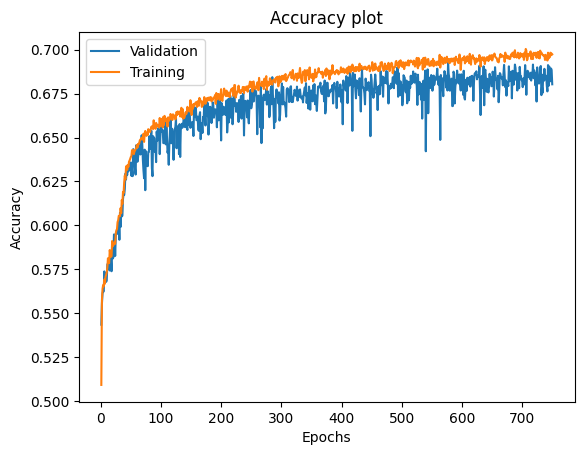

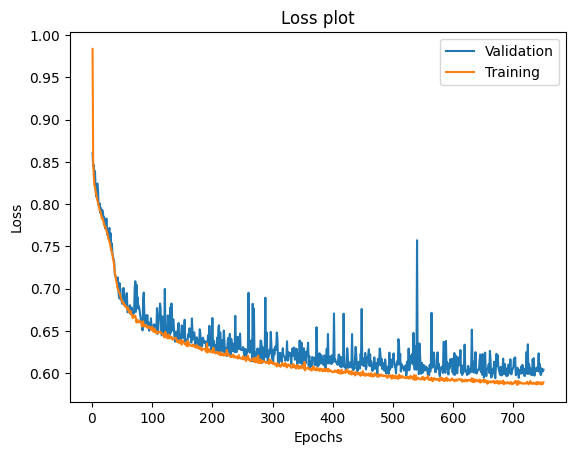

In [64]:
plot_epochs = [i for i in range(1, n_epochs + 1)]
plt.plot(plot_epochs, val_acc_per_epoch, label="Validation")
plt.plot(plot_epochs, history.history["accuracy"], label="Training")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.title("Accuracy plot")
plt.show()

plt.plot(plot_epochs, history.history["val_loss"], label="Validation")
plt.plot(plot_epochs, history.history["loss"], label="Training")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.title("Loss plot")
plt.show()

<a id='nn_eval'></a>
### 3.2.4 Model evaluation

To better visualize the type of errors in the model, let's calculate the confusion matrix.

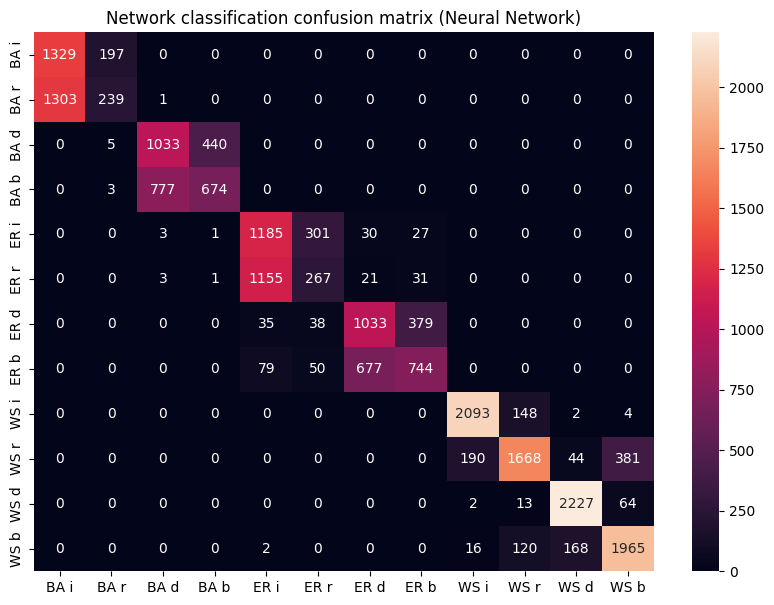

In [65]:
conf = confusion_matrix(y_test_labels, y_pred_labels)

index = [
    "BA i",
    "BA r",
    "BA d",
    "BA b",
    "ER i",
    "ER r",
    "ER d",
    "ER b",
    "WS i",
    "WS r",
    "WS d",
    "WS b",
]

df_cm = pd.DataFrame(conf, index=index, columns=index)
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, fmt="d").set_title(
    "Network classification confusion matrix (Neural Network)"
)
plt.show()

In [66]:
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

           0       0.50      0.87      0.64      1526
           1       0.54      0.15      0.24      1543
           2       0.57      0.70      0.63      1478
           3       0.60      0.46      0.52      1454
           4       0.48      0.77      0.59      1547
           5       0.41      0.18      0.25      1478
           6       0.59      0.70      0.64      1485
           7       0.63      0.48      0.54      1550
           8       0.91      0.93      0.92      2247
           9       0.86      0.73      0.79      2283
          10       0.91      0.97      0.94      2306
          11       0.81      0.87      0.84      2271

    accuracy                           0.68     21168
   macro avg       0.65      0.65      0.63     21168
weighted avg       0.68      0.68      0.66     21168



<a id='conclusion'></a>
## 4.  Conclusions

The main result of our project is that both Random Forest and the neural network are able to identify correctly whether a network has been attacked by a targeted attack, while they are unable to distinguish between intact and randomly-attacked networks. 
